In [1]:
%matplotlib inline
from pandas import Series, DataFrame
import pandas as pd
import operator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
import math
import json
import datetime
from pandas.io.json import json_normalize
matplotlib.rc('font',family='AppleGothic')

In [2]:
def getData(date):
    json_file = open("01_"+str(date)+"_heart.json", 'r')
    json_data = json_file.read()
    json_file.close()
    heart_json = json.loads(json_data)
    json_file = open("01_"+str(date)+"_steps.json", 'r')
    json_data = json_file.read()
    json_file.close()
    step_json = json.loads(json_data)
    json_file = open("01_"+str(date)+"_sleep.json", 'r')
    json_data = json_file.read()
    json_file.close()
    sleep_json = json.loads(json_data)
    heart_json_df = json_normalize(heart_json[ u'activities-heart-intraday'][u'dataset'])
    step_json_df = json_normalize(step_json[u'activities-steps-intraday'][u'dataset'])
    sleep_json_df = json_normalize(sleep_json[u'sleep'][0][u'minuteData'])
    sleep_json_df = sleep_json_df.rename(columns = {u'value':u'status'})

    step_json_df = step_json_df.rename(columns = {u'value':u'steps'})
    heart_json_df = heart_json_df.rename(columns = {u'value': u'heart_beat'})
    sleep_json_df = sleep_json_df.rename(columns = {u'dateTime':u'time'})
    sleep_json_df = sleep_json_df.fillna(4)
    for t in range(len(sleep_json_df[u'time'])):
        sleep_json_df[u'time'][t] = sleep_json_df[u'time'][t].split(':')[0] + ':' + sleep_json_df[u'time'][t].split(':')[1] + u':00'
        
    merge_data = step_json_df.merge(heart_json_df, left_on = u'time', right_on = u'time', how = 'outer')
    multiple_merge_data = merge_data.merge(sleep_json_df, left_on = u'time', right_on = u'time', how = 'outer')
    for t in range(len(multiple_merge_data[u'status'])):
        if pd.isnull(multiple_merge_data[u'status'][t]):
            multiple_merge_data[u'status'][t] = 4
    return multiple_merge_data

## 2016년 4월 1일 로그부터 2016년 4월 9일까지의 로그를 모으고 합친다
## 이 때 수면시간도 다른 시간과 같은 시간대로 (30초 단위 -> 0초 단위) 조절한다.

In [3]:
data_list = [20160401, 20160402, 20160403, 20160404, 20160405, 20160406, 20160407]
data_frame_list = list()
print "create training data set"
for i in data_list:
    print i
    data_frame_list.append(getData(i)) 

training_data = pd.concat(data_frame_list)
data_list = [20160408, 20160409]
data_frame_list = list()
print "create test data set"
for i in data_list:
    print i
    data_frame_list.append(getData(i)) 

test_data = pd.concat(data_frame_list)
training_data.to_csv('data.csv')

create training data set
20160401
20160402
20160403
20160404
20160405
20160406
20160407
create test data set
20160408
20160409


/Library/Python/2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## 걸음 수 와 심장박동 수와 비례 관계인지 확인한다.

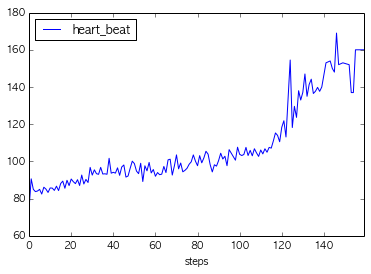

In [4]:
step_per_heat = training_data.groupby([u'steps']).mean()
step_per_heat.to_csv('average_heart_beat_per_steps.csv')
step_per_heat.plot()
test_step_per_heat = test_data.groupby([u'steps']).mean()
test_step_per_heat.to_csv('test_average_heart_beat_per_steps.csv')

In [5]:
dataset = pd.read_csv('average_heart_beat_per_steps.csv')
X = dataset[u'steps'].tolist()
Y = dataset[u'heart_beat'].tolist()

dataset = pd.read_csv('test_average_heart_beat_per_steps.csv')
testX = dataset[u'steps'].tolist()
testY = dataset[u'heart_beat'].tolist()

## 선형 회귀를 통해 심장박동 수를 예측해본다

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


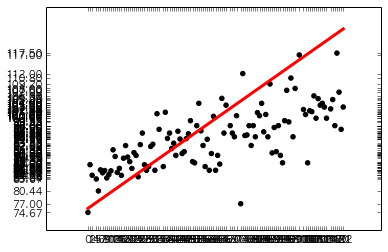

('Coefficients:', array([ 0.39542979]))
RMSE: 11.22
Variance score: -1.00


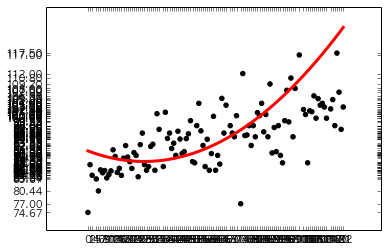

('Coefficients:', array([-0.21256604,  0.00397262]))
RMSE: 8.98
Variance score: -0.28


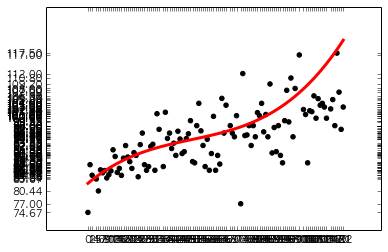

('Coefficients:', array([  4.71752614e-01,  -7.09165935e-03,   4.76228295e-05]))
RMSE: 7.37
Variance score: 0.14


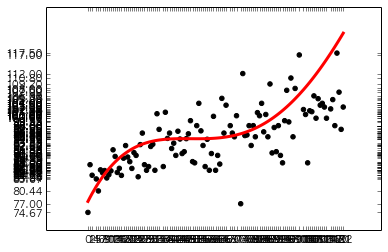

('Coefficients:', array([  1.11174990e+00,  -2.56466390e-02,   2.32667394e-04,
        -5.92111387e-07]))
RMSE: 7.60
Variance score: 0.08


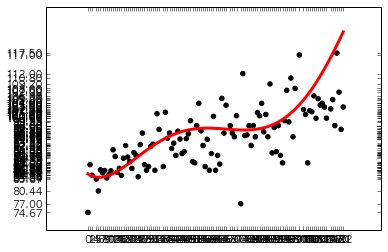

('Coefficients:', array([ -3.71046943e-01,   4.13624844e-02,  -9.11855781e-04,
         7.62848920e-06,  -2.09567280e-08]))
RMSE: 7.35
Variance score: 0.14


In [6]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
train_x, test_x = np.array(X), np.array(testX)
train_y, test_y = np.array(Y), np.array(testY)
train_x = train_x.reshape(-1, 1)
test_x =test_x.reshape(-1, 1)
for i in range(5):
    polynomial_features = PolynomialFeatures(degree=i+1,include_bias=False)
    regr = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", regr)])
    pipeline.fit(train_x, train_y)

    plt.scatter(test_x, test_y,  color='black')
    plt.plot(test_x, pipeline.predict(test_x), color='red', linewidth=3)
    plt.xticks(test_x)
    plt.yticks(test_y)
    plt.show()
    print('Coefficients:', regr.coef_)
    print("RMSE: %.2f" % np.sqrt(np.mean((pipeline.predict(test_x) - test_y) ** 2)))
    print('Variance score: %.2f' % pipeline.score(test_x, test_y))

## RMSE(Root Mean Square Error)가 크면 Underfit 너무 작으면 일반적으로 Overfit이라고 하는데
## 보통 RMSE값이 작은 경우에서 고르면 되는데 이 경우에는 High Variance 일 수록 Ovefit이므로
## 적당히 RMSE도 작고 Variance값도 작은 degree 가 3인 회귀 곡선이 심장박동 수 예측 모델과 가장 
## 적합하다고 생각이든다. RMSE: 7.37 Variance Score = 0.14

In [7]:
average_heat_pet_steps_with_status =  training_data.groupby([u'steps', u'status']).mean()
average_heat_pet_steps_with_status.to_csv('average_heart_beat_per_steps_with_status.csv')
test_average_heat_pet_steps_with_status =  test_data.groupby([u'steps', u'status']).mean()
test_average_heat_pet_steps_with_status.to_csv('test_average_heart_beat_per_steps_with_status.csv')

## 걸음 수 와 심장박동 수와 비례 관계인지 확인한다.
## status가 높을 수록 비수면 지수가 높은 것이다.
## 1 = 잠듬 2 = 약간 깸 3 = 방금 일어남 4 = 비수면(비수면 상태는 NaN값은 전부 비수면 상태로 후처리함)

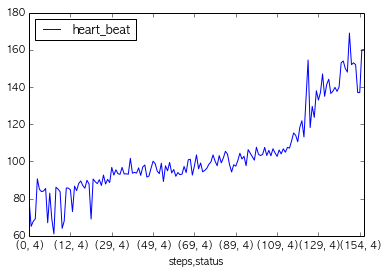

In [8]:
average_heat_pet_steps_with_status.plot()

## 선형 회귀를 통해 심장박동 수를 예측해본다

In [9]:
dataset = pd.read_csv('average_heart_beat_per_steps_with_status.csv')
X1 = dataset[u'steps'].tolist()
X2 = dataset[u'status'].tolist()
Y = dataset[u'heart_beat'].tolist()
X = zip(X1, X2)
dataset = pd.read_csv('test_average_heart_beat_per_steps_with_status.csv')
testX1 = dataset[u'steps'].tolist()
testX2 = dataset[u'status'].tolist()
testX = zip(testX1, testX2)
testY = dataset[u'heart_beat'].tolist()

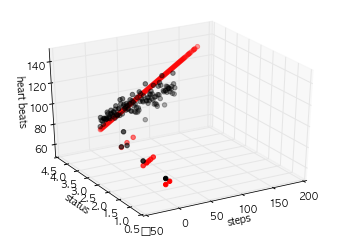

('Coefficients:', array([ 0.39675406,  4.36602422]))
RMSE: 11.09
Variance score: -0.57


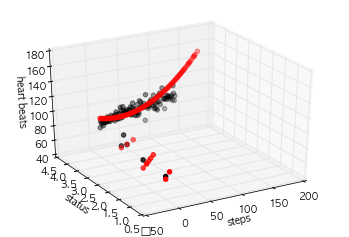

('Coefficients:', array([  1.99620080e+00,  -2.43317517e+01,   4.00610266e-03,
        -5.53660203e-01,   6.64291520e+00]))
RMSE: 8.91
Variance score: -0.02


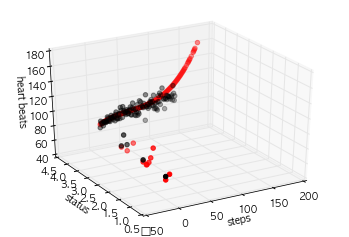

('Coefficients:', array([  2.45291190e+00,   3.64328773e+01,   3.60541915e-01,
        -3.79421457e+00,  -1.61382850e+01,   4.65477499e-05,
        -9.18348614e-02,   8.23243081e-01,   2.41345426e+00]))
RMSE: 7.49
Variance score: 0.28


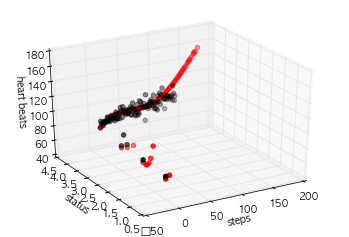

('Coefficients:', array([  1.38398794e-01,   3.10765115e+00,   8.88147600e-01,
        -4.06083148e+00,   3.71238769e+00,   1.25652402e-02,
        -6.06699734e-01,   2.27925249e+00,  -2.50334453e+00,
        -5.68151988e-07,  -3.08527432e-03,   9.46274437e-02,
        -3.01566260e-01,   4.15544610e-01]))
RMSE: 7.61
Variance score: 0.26


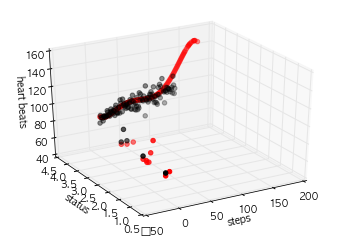

('Coefficients:', array([  2.87286127e-01,   6.26404089e-01,   8.89437950e-02,
         1.16272121e-01,   1.21761082e+00,   1.87381955e-01,
        -1.21259827e+00,   2.74307046e-01,   1.03518314e+00,
        -1.31436501e-02,   8.08504015e-02,  -1.92849987e-01,
         1.04001270e+00,  -9.44307235e-01,  -2.15137129e-08,
         3.28788026e-03,  -3.19833975e-02,   1.23300421e-01,
        -2.81880610e-01,   1.72343545e-01]))
RMSE: 7.21
Variance score: 0.34


In [10]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import interactive
train_x, test_x = np.array(X), np.array(testX)
train_y, test_y = np.array(Y), np.array(testY)


for i in range(5):
    polynomial_features = PolynomialFeatures(degree=i+1,include_bias=False)
    regr = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", regr)])
    pipeline.fit(train_x, train_y)

    threed_graph = plt.figure().gca(projection='3d')
    threed_graph.scatter(train_x.T[0].tolist(), train_x.T[1].tolist(),  pipeline.predict(train_x).tolist(),  color='red')
    threed_graph.scatter(test_x.T[0].tolist(),  test_x.T[1].tolist(), test_y.tolist(),  color='black')
    threed_graph.set_xlabel('steps')
    threed_graph.set_ylabel('status')
    threed_graph.set_zlabel('heart beats')
    threed_graph.view_init(30, 240)
    plt.show()
    print('Coefficients:', regr.coef_)
    print("RMSE: %.2f" % np.sqrt(np.mean((pipeline.predict(test_x) - test_y) ** 2)))
    print('Variance score: %.2f' % pipeline.score(test_x, test_y))

## RMSE(Root Mean Square Error)가 크면 Underfit 너무 작으면 일반적으로 Overfit이라고 하는데
## 보통 RMSE값이 작은 경우에서 고르면 되는데 이 경우에는 High Variance 일 수록 Ovefit이므로
## 적당히 RMSE도 작고 Variance값도 작은 degree 가 3인 회귀 곡선이 심장박동 수 예측 모델과 가장 
## 적합하다고 생각이든다. RMSE: 7.49 Variance Score = 0.28